# Import Library

In [1]:
from selenium import webdriver

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)
import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(action="ignore")

import urllib.request as req
from urllib.request import urlopen
from urllib.request import HTTPError, URLError
import urllib.parse
from bs4 import BeautifulSoup
import requests

from tqdm import tqdm_notebook
import time

import re

# 1. 데이터 파악 및 EDA

- 결과 변수 : 중식계, 석식계
- 원인 변수 : 일자, 요일, 본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 재택근무자수, 메뉴
- 파생 원인 변수 : 일자 -> 계절, 연도, 날씨(날씨 데이터 받아오기) // 인기메뉴 // 메뉴 카테고리화(어떻게 해야할지 고민해보기) // 실제 상주인원 계산 // 신메뉴 여부(New) // 명절 전날(날짜 계산?)
- 전처리 : 메뉴, 요일 one-hot encoding // 일자 : datetype으로 // 값들이 다 이산변수이므로 int64가 적합. 다 바꿔주자 // 결측치 확인해보기. '0'으로 표시되어있는지 확인

In [2]:
data = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/train.csv")
data

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB


In [5]:
# 해당 데이터 소스의 게시판에 의하면 2018년 6월 1일 요일이 잘못되었음을 확인
data["요일"][570:580]
# 18년 6월 1일, 월요일에서 금요일로 바꿔야함

570    화
571    수
572    목
573    월
574    월
575    화
576    목
577    금
578    월
579    화
Name: 요일, dtype: object

In [6]:
data["요일"][573] = "금"

In [7]:
# 다시 확인
data["요일"][570:580]
# 제대로 바뀌었음

570    화
571    수
572    목
573    금
574    월
575    화
576    목
577    금
578    월
579    화
Name: 요일, dtype: object

Text(0, 0.5, 'frequency')

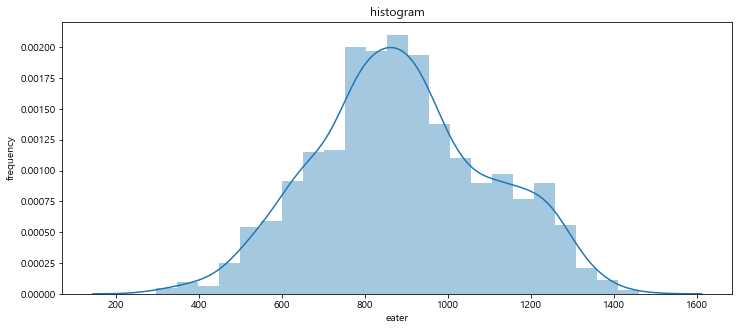

In [8]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)

ax = sns.distplot(data['중식계'])
ax.set_title("histogram")
ax.set_xlabel("eater")
ax.set_ylabel("frequency")

Text(0, 0.5, 'frequency')

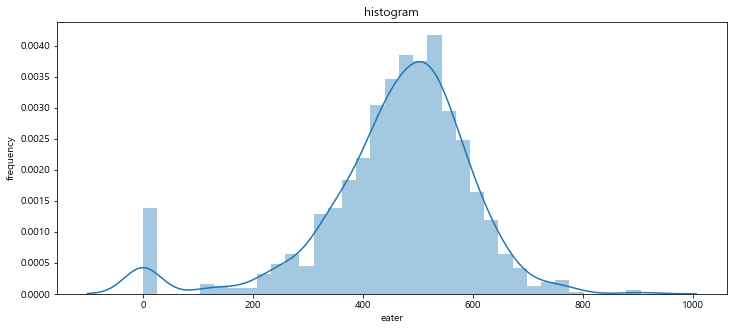

In [9]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 5)

ax = sns.distplot(data['석식계'])
ax.set_title("histogram")
ax.set_xlabel("eater")
ax.set_ylabel("frequency")

In [10]:
data.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


In [11]:
### 0?
data[data['석식계'] == 0]

# 주로 석식을 운영하지 않은 날이나, 2017년 9월 27일과 2018년 2월 4일은 석식 운영했음에도 0으로 처리되어있음
# 석식계 분석시엔 해당 내용들은 제거 후 분석해줘야 더 정확한 분석이 가능할 것으로 예상

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
204,2016-11-30,수,2689,68,207,0,0.0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 ...,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,1109.0,0.0
224,2016-12-28,수,2705,166,225,0,0.0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 ...,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,767.0,0.0
244,2017-01-25,수,2697,79,203,0,0.0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 ...,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,720.0,0.0
262,2017-02-22,수,2632,75,252,0,0.0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채...,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,1065.0,0.0
281,2017-03-22,수,2627,53,235,0,0.0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침...,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,953.0,0.0
306,2017-04-26,수,2626,45,304,0,0.0,모닝롤/와플 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 된장찌개 검정콩조...,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,835.0,0.0
327,2017-05-31,수,2637,43,265,0,0.0,모닝롤/베이글 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 자...,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,910.0,0.0
346,2017-06-28,수,2648,58,259,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 쇠고기매운국 고...,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,745.0,0.0
366,2017-07-26,수,2839,254,246,0,0.0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 민물새우찌개 숙...,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,797.0,0.0
392,2017-09-01,금,2642,177,303,45,0.0,모닝롤/단팥빵 우유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 대구찌개 깻순나...,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,663.0,0.0


<AxesSubplot:xlabel='요일', ylabel='중식계'>

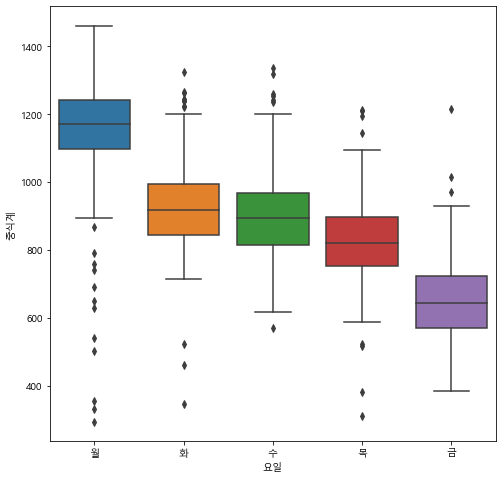

In [12]:
#### 요일별 중식계, 석식계
#### 평균적으로 월요일에 가장 많이 찾아오지만, 항상 그렇지 않다. 오차범위 밖에 최소값들이 많이 있음을 알 수 있다.
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(8, 8)
sns.boxplot(x='요일', y='중식계', data=data)

<AxesSubplot:xlabel='요일', ylabel='석식계'>

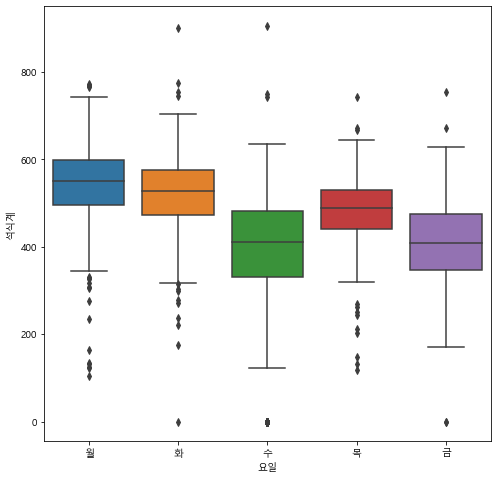

In [13]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(8, 8)

sns.boxplot(x='요일', y='석식계', data=data)

# 코로나 이후 관련 데이터 EDA
+ 2020-3-20부터 코로나19로 인한 재택근무 활성화
+ 1010번째 인덱스부터 재택근무자가 폭증한 것을 확인할 수 있음

In [14]:
data.iloc[1000:1030, :7]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
1000,2020-03-06,금,2950,166,251,0,12.0
1001,2020-03-09,월,2950,91,129,784,16.0
1002,2020-03-10,화,2950,67,168,678,20.0
1003,2020-03-11,수,2950,74,197,0,23.0
1004,2020-03-12,목,2950,78,243,555,17.0
1005,2020-03-13,금,2950,165,259,0,20.0
1006,2020-03-16,월,2950,69,138,789,21.0
1007,2020-03-17,화,2950,61,171,679,20.0
1008,2020-03-18,수,2950,47,210,0,25.0
1009,2020-03-19,목,2950,70,235,560,19.0


<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='중식계'>

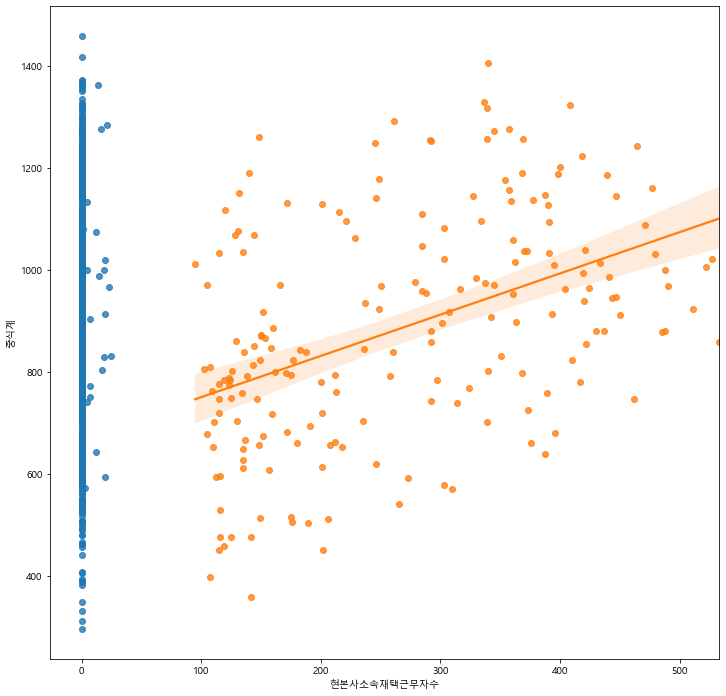

In [15]:
#코로나 이후, 재택근무자수와 중식계 관계. 뚜렷한 선형관계를 보이고 있진 않다. (많이 퍼져있음)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)

sns.regplot(x='현본사소속재택근무자수', y='중식계', data=data.iloc[:1010], fit_reg=False) # 재택근무 활성화 이전
sns.regplot(x='현본사소속재택근무자수', y='중식계', data=data.iloc[1010:], fit_reg=True) # 코로나로 인한 재택근무 활성화 이후

<AxesSubplot:xlabel='현본사소속재택근무자수', ylabel='석식계'>

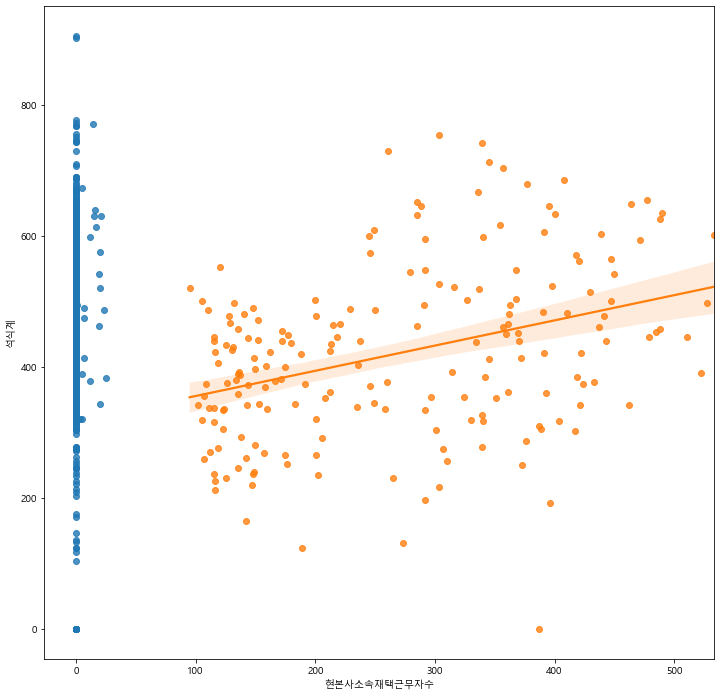

In [16]:
#코로나 이후, 재택근무자수와 석식계 관계. 마찬가지로 뚜렷한 선형관계를 보이고 있진 않다. (많이 퍼져있음)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12, 12)

sns.regplot(x='현본사소속재택근무자수', y='석식계', data=data.iloc[:1010], fit_reg=False) # 재택근무 활성화 이전
sns.regplot(x='현본사소속재택근무자수', y='석식계', data=data.iloc[1010:], fit_reg=True) # 코로나로 인한 재택근무 활성화 이후

In [17]:
# 사내 인원 관련 숫자와 중식계, 석식계의 관계를 상관관계로

# 1. 데이터 슬라이싱
data_a = data.loc[:, ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식계', '석식계']]
data_a

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
0,2601,50,150,238,0.0,1039.0,331.0
1,2601,50,173,319,0.0,867.0,560.0
2,2601,56,180,111,0.0,1017.0,573.0
3,2601,104,220,355,0.0,978.0,525.0
4,2601,278,181,34,0.0,925.0,330.0
...,...,...,...,...,...,...,...
1200,2983,75,198,4,391.0,1093.0,421.0
1201,2983,92,231,462,351.0,832.0,353.0
1202,2983,255,248,1,303.0,579.0,217.0
1203,2983,107,153,616,327.0,1145.0,502.0


In [18]:
# 2. 휴가자, 출장자, 재택근무자 제외한 실제 본사 내 정원 파악해보기

data_a['실질정원수'] = data_a['본사정원수'] - (data_a['본사휴가자수'] + data_a['본사출장자수'] + data_a['현본사소속재택근무자수'])
# 3. 생성한 파생변수 위치 변경
data_a = data_a.loc[:, ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

# int로 변경
data_a = data_a.astype(np.int64)
data_a

,중식계,석식계,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,1039,331,2601,2401,50,150,238,0
1,867,560,2601,2378,50,173,319,0
2,1017,573,2601,2365,56,180,111,0
3,978,525,2601,2277,104,220,355,0
4,925,330,2601,2142,278,181,34,0
...,...,...,...,...,...,...,...,...
1200,1093,421,2983,2319,75,198,4,391
1201,832,353,2983,2309,92,231,462,351
1202,579,217,2983,2177,255,248,1,303
1203,1145,502,2983,2396,107,153,616,327


In [19]:
data_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   중식계             1205 non-null   int64
 1   석식계             1205 non-null   int64
 2   본사정원수           1205 non-null   int64
 3   실질정원수           1205 non-null   int64
 4   본사휴가자수          1205 non-null   int64
 5   본사출장자수          1205 non-null   int64
 6   본사시간외근무명령서승인건수  1205 non-null   int64
 7   현본사소속재택근무자수     1205 non-null   int64
dtypes: int64(8)
memory usage: 75.4 KB


<AxesSubplot:>

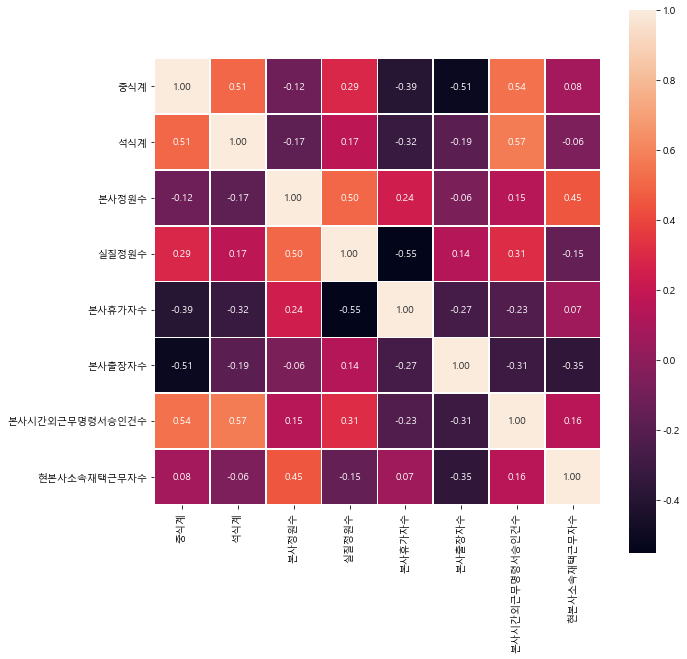

In [20]:
cols = ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']

plt.figure(figsize=(10,10))

heat = np.corrcoef(data_a[cols].T)
sns.heatmap(heat, annot=True, yticklabels=cols, xticklabels=cols, fmt='.2f', linewidths=.5, square=True)


 + 중식계(점심)은 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수
 + 이 세 값이 상관관계가 큰 이유는 휴가자와 출장자는 근무지에 없어서!
 + 점심이 본사시간외근무명령서승인건수와 관련 있는 이유는 바쁘니까 야근하고 바쁘니까 밖에서 밥먹을 시간이 없는 것으로 이해


<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='중식계'>

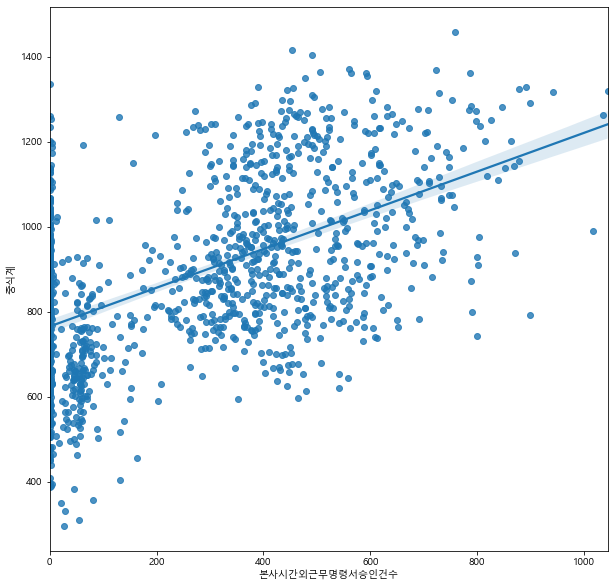

In [21]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 10)

sns.regplot(x="본사시간외근무명령서승인건수", y='중식계', data=data_a)

<AxesSubplot:xlabel='본사시간외근무명령서승인건수', ylabel='석식계'>

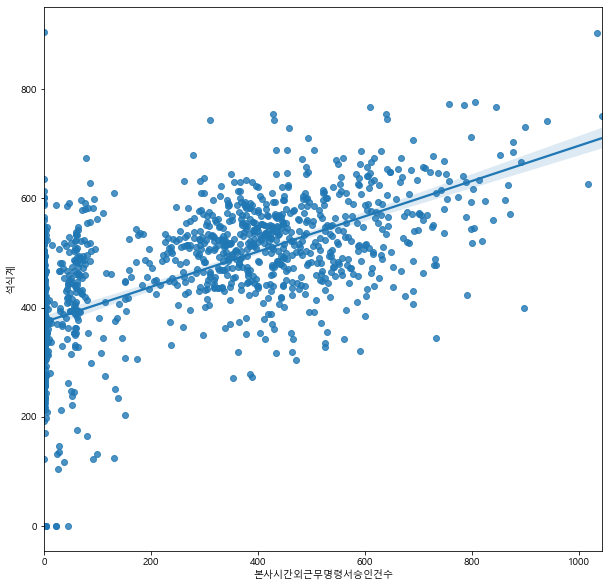

In [22]:
# 데이터가 선형관계에 있으나 근무명령승인건수에 관계없이 석식계, 중식계 발생하는 건수도 많음을 알 수 있음
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 10)

sns.regplot(x="본사시간외근무명령서승인건수", y='석식계', data=data_a)

<AxesSubplot:xlabel='중식계', ylabel='석식계'>

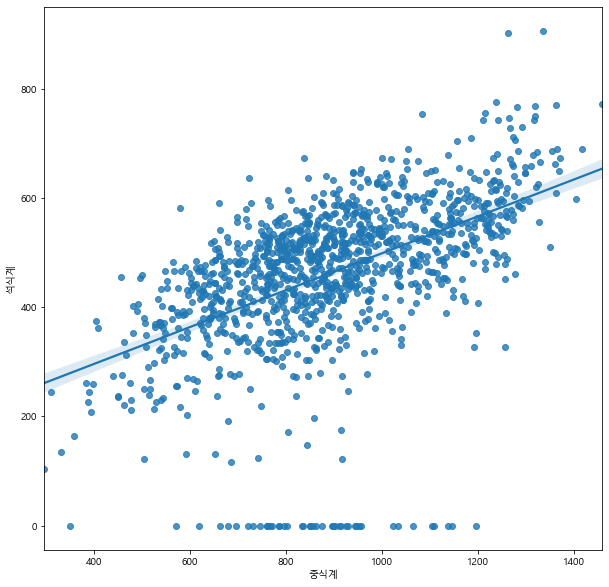

In [23]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(10, 10)

sns.regplot(x="중식계", y='석식계', data=data_a)
# 중식계가 많은 날, 석식계도 많다 :)
# 석식계를 예측할 땐, 중식계를 원인변수로 두는 것도 하나의 방법

# 2. 데이터 변경

## 1. 데이터 형태 변경
- 일자 -> 날짜 데이터 형태로
- 인원 수 -> int로 :: 해당 데이터 기준은 인원 수이고 사람은 정확히 끊어서 셀 수 있다.

In [24]:
data['일자'] = pd.to_datetime(data['일자'])
#df['Datetime'] = df['Datetime'].apply(lambda _: datetime.strptime(_,"%m/%d/%Y, %H:%M:%S"))
data

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0


In [25]:
data['현본사소속재택근무자수'] = data['현본사소속재택근무자수'].astype(np.int64)
data['중식계'] = data['중식계'].astype(np.int64)
data['석식계'] = data['석식계'].astype(np.int64)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   int64         
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int64         
 11  석식계             1205 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 113.1+ KB


In [27]:
### 시계열에 따른 변화량을 시각화.
### 1. date type을 인덱스로
data_timegraph = data.set_index('일자')
data_timegraph

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
일자,,,,,,,,,,,
2016-02-01,월,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331
2016-02-02,화,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560
2016-02-03,수,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573
2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525
2016-02-05,금,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-20,수,2983,75,198,4,391,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421
2021-01-21,목,2983,92,231,462,351,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353
2021-01-22,금,2983,255,248,1,303,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217


<AxesSubplot:xlabel='일자'>

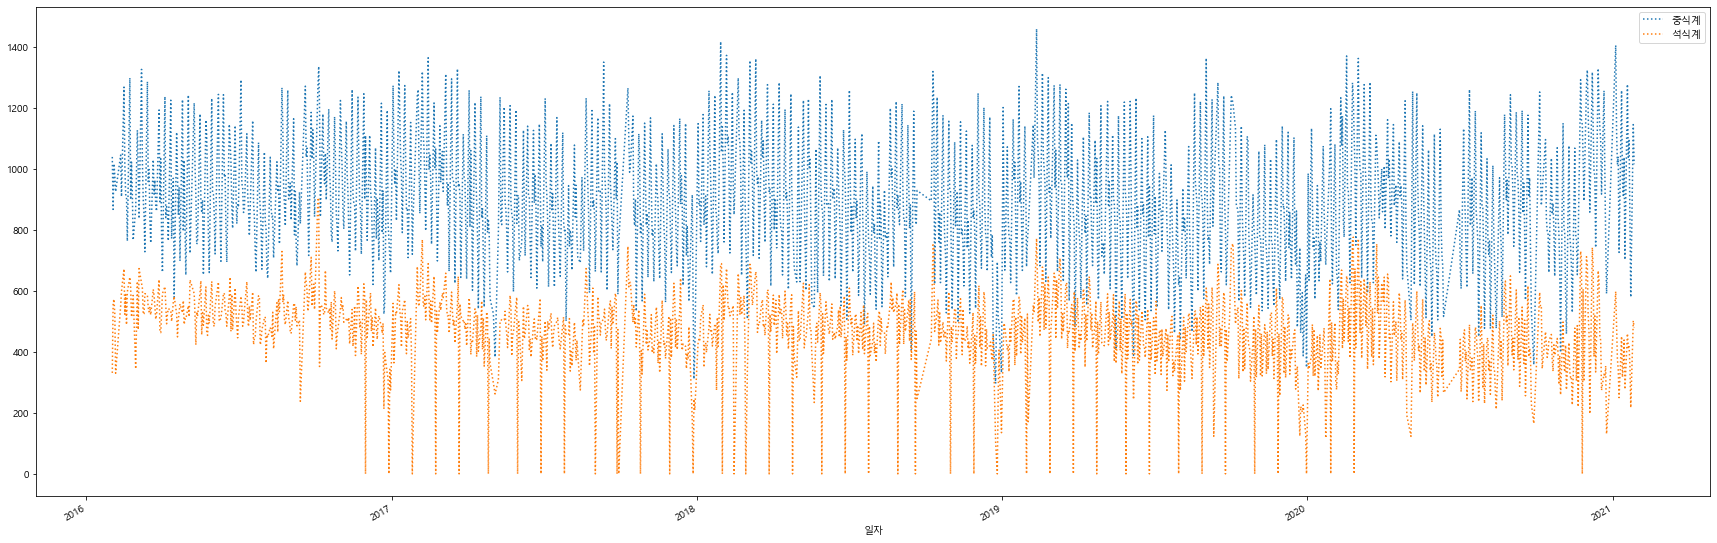

In [28]:
### 2. 중식계와 석식계 변화량 파악
### 매년, 계절별, 월별로 일정한 패턴을 보이는 듯함
### 중식계와 석식계는 비슷한 증감 패턴을 보인다
### 코로나 직후, 석식량은 오히려 코로나 전에 비해 늘어난 모습을 보인다.
graph = data_timegraph.loc[:, ['중식계', '석식계']]
graph.plot(figsize=(30,10), ls=':')

<AxesSubplot:xlabel='일자'>

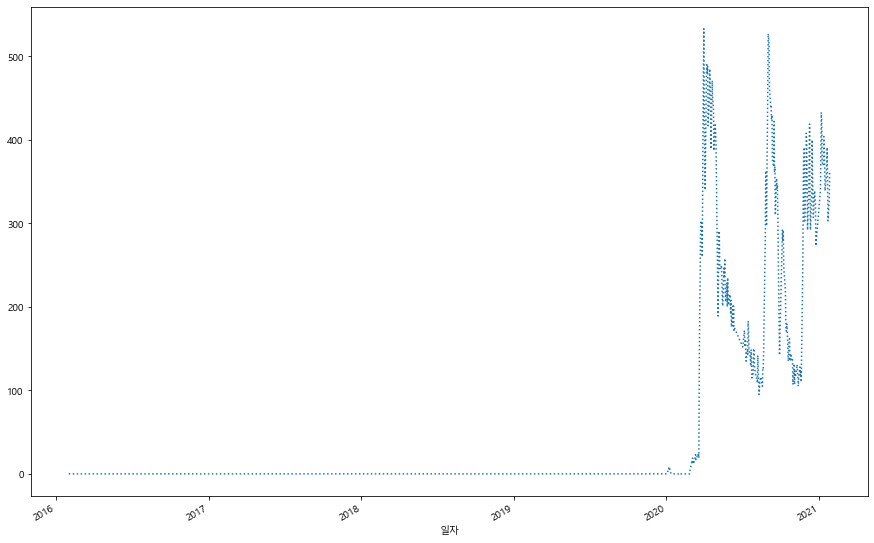

In [47]:
### 3. 재택근무자 수 변화량 파악
### 코로나 19 이 후 급격히 늘어나는 모습을 보임
graph = data_timegraph.loc[:, '현본사소속재택근무자수']
graph.plot(figsize=(15,10), ls=':')

<AxesSubplot:xlabel='일자'>

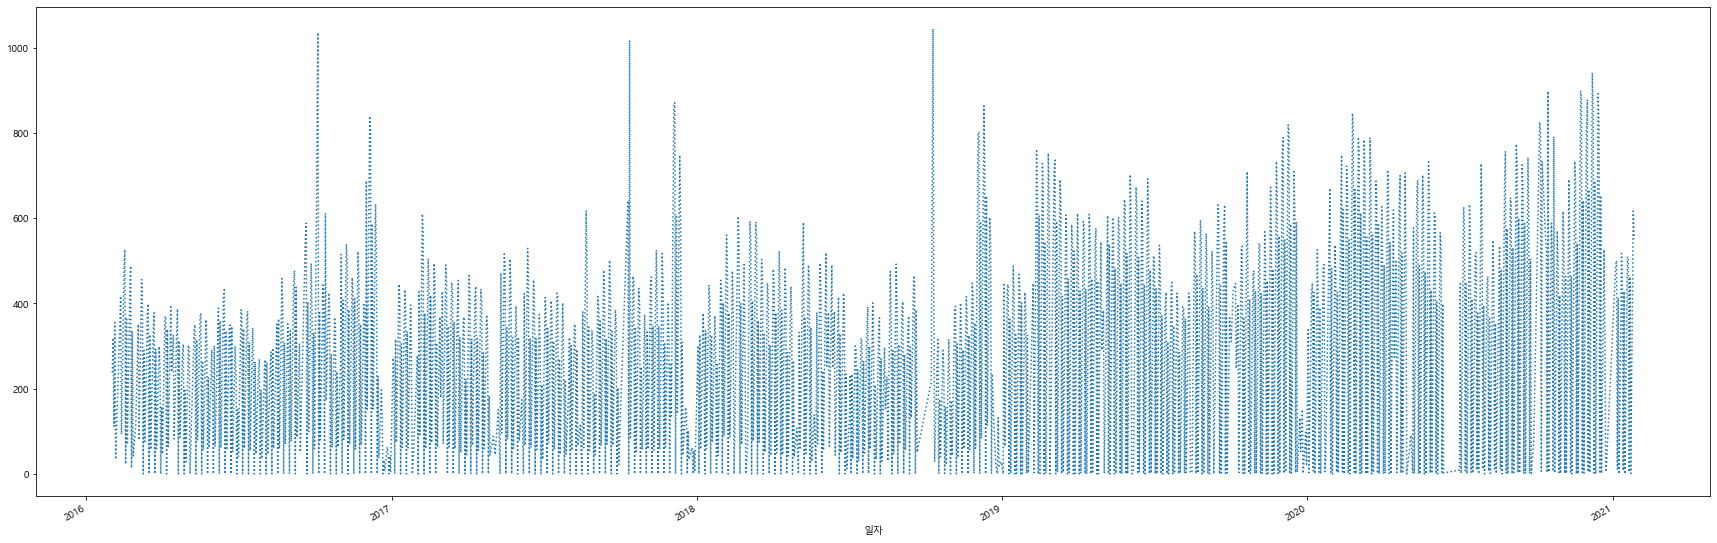

In [29]:
### 4. 야근자 수 변화량 파악
### 16년, 17년, 18년엔 특정 날짜에 시간외근무명령승인건수가 증가
### 다만, 19년과 20년도엔 이러한 패턴이 안보임.
### 이유를 찾고 21년도는 이를 기준으로 야근자 수가 늘어날지 안늘어날지 파악하는 것 필요해보임
graph = data_timegraph.loc[:, '본사시간외근무명령서승인건수']
graph.plot(figsize=(30,10), ls=':')

## 2. 근무자 관련 파생변수
- 사내 실 근무자 수 파악

In [30]:
data.head()
data=data.reset_index()

In [31]:
data['실질정원수'] = data['본사정원수'] - (data['본사휴가자수'] + data['본사출장자수'] + data['현본사소속재택근무자수'])

data = data.loc[:, ['일자', '요일', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', '중식메뉴', '석식메뉴', '중식계', '석식계']]
data['일자'] = pd.to_datetime(data['일자'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   int64         
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   int64         
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int64         
 11  석식계             1205 non-null   int64         
dtypes: datetime64[ns](1), int64(8), object(3)
memory usage: 113.1+ KB


## 3. 일자에서 계절, 연도, 월, 날 뽑아내기

In [32]:
data['일자']

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]

In [33]:
data['Month'] = data['일자'].dt.strftime('%m')
data['Date'] = data['일자'].dt.strftime('%d')
# data['Month'] = data['일자'].dt.month
# data['Date'] = data['일자'].dt.day

data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,02,01
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,02,02
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,02,03
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,02,04
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,02,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,01,20
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,01,21
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,01,22
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,01,25


In [36]:
print(data['Month'])
data.info() #Month가 문자열로 인식

0       02
1       02
2       02
3       02
4       02
        ..
1200    01
1201    01
1202    01
1203    01
1204    01
Name: Month, Length: 1205, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   int64         
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   int64         
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int64         
 11  석식계             1205 non-null   int64         
 12

In [38]:
### 계절추가
season = []

# for index in range(len(data)):
#     if data['Month'][index] == '03' or data['Month'][index] == '04' or data['Month'][index] == '05':
#         season.append('봄')
#     elif data['Month'][index] == '06' or data['Month'][index] == '07' or data['Month'][index] == '08':
#         season.append('여름')
#     elif data['Month'][index] == '09' or data['Month'][index] == '10' or data['Month'][index] == '11':
#         season.append('가을')
#     elif data['Month'][index] == '12' or data['Month'][index] == '01' or data['Month'][index] == '02':
#         season.append('겨울')

for index in range(len(data)):
    if data['Month'][index] in ["03", "04", "05"]:
        season.append('봄')
    elif data['Month'][index] in ["06", "07", "08"]:
        season.append('여름')
    elif data['Month'][index] in ["09", "10", "11"]:
        season.append('가을')
    elif data['Month'][index] in ["12", "01", "02"]:
        season.append('겨울')

len(season)

1205

In [39]:
data['Season'] = season
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,02,01,겨울
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,02,02,겨울
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,02,03,겨울
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,02,04,겨울
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,02,05,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,01,20,겨울
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,01,21,겨울
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,01,22,겨울
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,01,25,겨울


# Checkpoint(2022.01.04 5pm)
- 데이터 타입 변경 / 실제 사내 근무자 수 파악 / 계절 변수 추가

In [40]:
data.to_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv", encoding='utf-8', index=False)

## 4. 메뉴
- 조식메뉴제거(앞에서 이미 제거 했음)
- 신메뉴 출시 카테고리 만들어주기
- 중식, 석식 메뉴에서 주요 메뉴 뽑아내기
- 메뉴 카테고리화 밥 or 특별식 밥 // 메인메뉴 // 국
- 중식, 석식 신메뉴 Yes or No 칼럼 만들기


In [41]:
data = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv")
data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2,1,겨울
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2,2,겨울
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2,3,겨울
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2,4,겨울
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2,5,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,1,20,겨울
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,1,21,겨울
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,1,22,겨울
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,1,25,겨울


In [42]:
#밥
print(data['중식메뉴'][0].split(' ')[0])
#국
print(data['중식메뉴'][0].split(' ')[2])
#메인반찬
print(data['중식메뉴'][0].split(' ')[4])

### 밥이 메인이면?
#밥
print(data['중식메뉴'][2].split(' ')[0])
#국
print(data['중식메뉴'][2].split(' ')[2])
#메인반찬
print(data['중식메뉴'][2].split(' ')[4])


### 뒤엔 원산지가 없어서 순서가 다르다. 단순 반복문과 split으론 원하는 결과물 얻을 수 없다.
#밥
print(data['중식메뉴'][1202].split(' ')[0])
#국 #요거닭이 나와
print(data['중식메뉴'][1202].split(' ')[2])
#메인반찬
print(data['중식메뉴'][1202].split(' ')[4])

# 일관된 결과물 얻으려면 원산지 정보를 제거해줘야한다.
# split으로 나누고 반복문과 조건문으로 ()가 있으면 제거하라는 명령어 통해 원산지 정보만 없앨 수 있다.

쌀밥/잡곡밥
오징어찌개
쇠불고기
카레덮밥
팽이장국
치킨핑거
전주비빔밥*약고추장
요거닭
파프리카해초무침


In [43]:
'New' in data['석식메뉴'][1204]

True

In [44]:
New_lunch = []
New_dinner = []

for index in range(len(data)):
    if 'New' in data['중식메뉴'][index]:
        New_lunch.append(1)
    else:
        New_lunch.append(0)

for index in range(len(data)):
    if 'New' in data['석식메뉴'][index]:
        New_dinner.append(1)
    else:
        New_dinner.append(0)

print(len(New_lunch))
print(len(New_dinner))

1205
1205


In [45]:
data['New_lunch'] = New_lunch
data['New_dinner'] = New_dinner

data

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2,1,겨울,0,0
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2,2,겨울,0,0
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2,3,겨울,0,0
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2,4,겨울,0,0
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2,5,겨울,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093,421,1,20,겨울,0,0
1201,2021-01-21,목,2983,2309,92,231,462,351,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832,353,1,21,겨울,0,0
1202,2021-01-22,금,2983,2177,255,248,1,303,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579,217,1,22,겨울,0,0
1203,2021-01-25,월,2983,2396,107,153,616,327,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145,502,1,25,겨울,0,0


### 1. 중식

In [46]:
# 일별 점심메뉴를 작은 리스트로 갖고 있는 큰 리스트 (lunch) 만들기 
lunch = []

for index in range(len(data)):
    tmp = data.loc[index,'중식메뉴'].split(' ') # 스페이스로 구분
    tmp = ' '.join(tmp).split()    # 빈칸 제거

    # ()안에 있는 내용 제거
    for menu in tmp:
        if '(' in menu:
            tmp.remove(menu)
    lunch.append(tmp) 

In [47]:
for index in range(len(data)): # 밥은 큰 차이가 없을것같으므로 쌀밥은 다 밥으로 통일
    if '쌀밥' in lunch[index][0]:
        lunch[index][0] = '밥'

In [48]:
for i, v in enumerate(lunch, start=1):
    print(i, v)

1 ['밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치']
2 ['밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이']
3 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치']
4 ['밥', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치']
5 ['밥', '떡국', '돈육씨앗강정', '우엉잡채', '청경채무침', '요구르트', '포기김치']
6 ['밥', '시래기국', '훈제오리구이', '도토리묵무침', '쌈무/양파절임', '요구르트', '포기김치']
7 ['밥', '꽃게탕', '돈육굴소스볶음', '옥수수전', '유채나물', '요구르트', '포기김치']
8 ['밥', '시금치국', '닭감자조림', '연두부*양념장', '콩나물무침', '요구르트', '포기김치']
9 ['밥', '쇠고기무국', '탕수어', '오징어숙회무침', '취나물', '요구르트', '포기김치']
10 ['밥', '냉이된장국', '쇠고기장조림', '통도라지구이', '치커리무침', '요구르트', '포기김치']
11 ['낙지비빔밥', '유부장국', '고구마치즈구이', '해초무침', '요구르트', '요구르트', '포기김치']
12 ['밥', '대구찌개', '마늘간장치킨', '새송이버섯볶음', '돌나물무침/치킨무', '요구르트', '포기김치']
13 ['밥', '쇠고기느타리국', '갈치구이', '호박꼬지&고사리&무나물', '파래김*양념장', '부럼/요구르트', '포기김치']
14 ['밥', '콩나물국', '돈육간장볶음', '버섯잡채', '꽃상추무침', '요구르트', '포기김치']
15 ['비빔밥', '팽이장국', '소세지피망볶음', '맛탕', '귤', '요구르트', '포기김치']
16 ['밥', '북어계란국', '닭갈비', '새싹두부구이', '곰피초장', '요구르트', '포기김치']
17 ['밥', '수제비국', '오징

798 ['밥', '아욱국', '제육볶음', '해파리겨자채', '호박나물', '포기김치']
799 ['밥', '차돌된장찌개', '해물청경채볶음', '고기전', '미역줄기볶음', '포기김치']
800 ['산채비빔밥', '가쯔오장국', '치킨너겟*머스타드', '콘샐러드', '연근땅콩조림', '포기김치']
801 ['밥', '연두부탕', '돼지갈비찜', '계란말이', '취나물', '포기김치']
802 ['밥', '버섯매운탕', '탕수어', '온두부', '치커리유자청무침', '볶음김치']
803 ['밥', '된장찌개', '소고기숙주나물볶음', '코다리조림', '방풍나물', '포기김치']
804 ['밥', '해물순두부찌개', '수원왕갈비통닭', '사각어묵볶음', '참나물생채', '열무김치']
805 ['밥', '꽃게탕', '새송이떡갈비구이', '도토리묵야채무침', '연두부*양념장', '포기김치']
806 ['밥', '소고기국', '가자미튀김', '돈육장조림', '시금치고추장무침', '포기김치']
807 ['낙지비빔밥', '콩나물국', '부추전', '계란찜', '땅콩조림', '포기김치']
808 ['밥', '북어국', '돈육콩나물불고기', '시금치프리타타', '쫑상추무침', '포기김치']
809 ['밥', '오징어국', '안동찜닭', '감자채전', '오이소박이', '포기김치']
810 ['밥', '배추된장국', '수제돈가스', '마파두부', '돈나물유자청무침', '포기김치']
811 ['밥', '육개장', '고등어구이', '야채비빔만두', '파래김*양념장', '깍두기']
812 ['봄나물비빔밥', '맑은국', '함박스테이크', '동태전', '마늘쫑무침', '포기김치']
813 ['밥', '콩나물국', '짬뽕불고기', '메추리알조림', '모듬쌈*쌈장', '포기김치']
814 ['밥', '아욱국', '등갈비김치찜', '두부계란부침', '콩나물무침', '열무김치']
815 ['곤드레밥*양념장', '맑은국', '코다리조림', '계란말이', '과일샐러드', '포기김치']
816 

In [49]:
# 밥, 국, 메인반찬1 로 나누기
# 원핫 인코딩하면 너무 길어질 거 같은데.. 간단히 카테고리화할 방법 찾아야하나?
# 길이 신경 안써도 되나?
rice=[]
soup=[]
main=[]

for i in range(len(data)):
    if lunch[i][0]:
        rice.append(lunch[i][0])
    if lunch[i][1]:
        soup.append(lunch[i][1])
    if lunch[i][2]:
        main.append(lunch[i][2])

data['lunch_rice'] = rice
data['lunch_soup'] = soup
data['lunch_main'] = main


In [50]:
print(data['lunch_rice'].unique())

['밥' '카레덮밥' '낙지비빔밥' '비빔밥' '곤드레밥' '콩나물밥*달래장' '봄새싹비빔밥' '콩나물밥' '나물비빔밥'
 '단호박영양밥' '산채비빔밥' '낙지볶음밥' '열무비빔밥' '참치회덮밥' '연복풍덮밥' '열무보리비빔밥' '불고기덮밥'
 '산채비빔밥*강된장' '짜장밥' '버섯영양밥' '소불고기덮밥' '오곡밥' '곤드레밥*강된장' '봄나물비빔밥' '카레라이스'
 '짜장덮밥' '<초복특식>' '김치제육덮밥' '곤드레밥*간장양념' '단호박카레라이스' '곤드레밥*양념장' '삼계탕'
 '콩나물밥*양념장' '마파두부덮밥' '야채볶음밥*짜장소스' '김치볶음밥' '오므라이스' '김치볶음밥/계란' '파인애플볶음밥'
 '김치필라프' '불고기비빔밥' '김밥볶음밥' '고기듬뿍카레라이스' '건강비빔밥*약고추장' '새우날치알볶음밥' '소고기콩나물밥*양념'
 '닭살카레라이스' '열무보리비빔밥/강된장' '베이컨김치볶음밥' '돈육버섯고추장덮밥' '비빔밥*약고추장' '낙지비빔밥*계란후라이'
 '계란채소볶음밥' '전주비빔밥' '호박된장국' '전주비빔밥*약고추장']


In [51]:
data[data['lunch_rice'] == '<초복특식>']
#이거 어떻게 처리할까? 그냥 둘까?

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main
356,2017-07-12,수,2839,2507,69,263,0,0,"<초복특식> 삼계탕 (닭:국내산) 찹쌀밥 (찹쌀,쌀:국내산) 생야채&쌈장 수박 ...",쌀밥/잡곡밥 (쌀:국내산) 해물된장찌개 모둠장조림 참치야채전 노각무침 포기김...,918,414,7,12,여름,0,0,<초복특식>,삼계탕,찹쌀밥
840,2019-07-12,금,2760,2210,244,306,0,0,"<초복특식> 삼계탕 (닭:국내산) 찹쌀밥 (찹쌀,쌀:국내산) 생야채&쌈장 수박 ...",쌀밥/잡곡밥 (쌀:국내산) 된장찌개 소고기장조림 (쇠고기:호주산) 비엔나케찹볶음 ...,856,385,7,12,여름,0,0,<초복특식>,삼계탕,찹쌀밥


In [52]:
data.tail(30)

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main
1175,2020-12-08,화,2990,2259,172,182,852,377,쌀밥/기장밥/찰현미밥 우거지국 훈제오리마늘볶음 아귀콩나물찜 봄동나물 포기김치/꿀호떡...,김치볶음밥 미소된장국 수제등심찹쌀꿔바로우 계란후라이 실곤약채소무침 석박지,1138,679,12,8,겨울,0,0,밥,우거지국,훈제오리마늘볶음
1176,2020-12-09,수,2990,2181,199,191,2,419,쌀밥/흑미밥/찰현미밥 호박고추장찌개 만가닥버섯불고기 치즈계란찜 크래미해초무침 겉절이...,흑미밥 부대찌개 해물볶음 메추리알꽈리고추조림 참나물무침 포기김치,994,384,12,9,겨울,0,0,밥,호박고추장찌개,만가닥버섯불고기
1177,2020-12-10,목,2990,2212,212,229,683,337,쌀밥/수수밥/찰현미밥 북엇국 제육고추장불고기 고등어카레구이 알배기/상추*쌈장 깍두기...,미트볼파스타*추가밥 유부장국 딤섬 브로콜리숙회*초장 열무된장나물 포기김치,975,518,12,10,겨울,0,0,밥,북엇국,제육고추장불고기
1178,2020-12-11,금,2990,2072,398,228,0,292,쌀밥/흑미밥/찰현미밥 근대국 닭다리살스테이크 단호박채소전 진미채오이무침 포기김치 양...,흑미밥 컵라면&찐계란 수제오징어튀김 매운떡볶이*순대찜 단무지무침 포기김치,742,334,12,11,겨울,0,0,밥,근대국,닭다리살스테이크
1179,2020-12-14,월,2990,2291,221,142,892,336,쌀밥/흑미밥/찰현미밥 (New)누룽지장각백숙 (New)캔꽁치튀김 쫄면채소무침 풋고추...,흑미밥 꼬치어묵매운탕 쇠고기청경채볶음 새송이버섯조림 깻잎고기전 포기김치,1329,666,12,14,겨울,1,0,밥,(New)캔꽁치튀김,쫄면채소무침
1180,2020-12-15,화,2990,2208,203,179,814,400,쌀밥/차조밥/찰현미밥 굴떡국 콩나물파채불고기 쌈배추/양상추*쌈장 건취나물볶음 포기김...,고추잡채덮밥 손수제비국 (New)칠리가지탕수 자장소스 단무지무침 포기김치,1202,633,12,15,겨울,0,1,밥,굴떡국,콩나물파채불고기
1181,2020-12-16,수,2990,2249,195,187,1,359,쌀밥/흑미밥/찰현미밥 (New)돈갈비김치찌개 해물완자전 가자미무조림 시금치나물 겉절...,흑미밥 쇠고기무국 오징어떡볶음 물파래초무침 숙주미나리나물 포기김치,1135,450,12,16,겨울,1,0,밥,해물완자전,가자미무조림
1182,2020-12-17,목,2990,2246,226,184,653,334,쌀밥/흑미밥/찰현미밥 (New)인도커리&난 (New)탄두리치킨 문어꽈리고추조림 세발...,흑미밥 순두부백탕*양념장 제육간장불고기 매운감자조림 (New)배추오이흑임자무침 포기김치,1096,438,12,17,겨울,1,1,밥,(New)탄두리치킨,문어꽈리고추조림
1183,2020-12-18,금,2990,2084,403,196,1,307,쌀밥/흑미밥/찰현미밥 동태알탕 수제돈까스&소스 청양고추계란말이 달래무침 포기김치 양...,흑미밥 맑은버섯닭개장 참치김치볶음 도토리묵*양념장 쑥갓겉절이 깍두기,917,274,12,18,겨울,0,0,밥,동태알탕,수제돈까스&소스
1184,2020-12-21,월,2990,2250,248,153,526,339,쌀밥/흑미밥/찰현미밥 바지락살무국 오삼불고기 소고기잡채 유채나물무침 포기김치/새알팥...,(New)치킨마요덮밥 팽이장국 (New)어떡햄 계란후라이 도라지초무침 김치볶음,1256,327,12,21,겨울,0,1,밥,바지락살무국,오삼불고기


# Checkpoint (2022-01-05 2pm)

In [53]:
data.to_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv", encoding='utf-8', index=False)

In [54]:
data = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv")
data.head(10)

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,Month,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main
0,2016-02-01,월,2601,2401,50,150,238,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2,1,겨울,0,0,밥,오징어찌개,쇠불고기
1,2016-02-02,화,2601,2378,50,173,319,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2,2,겨울,0,0,밥,김치찌개,가자미튀김
2,2016-02-03,수,2601,2365,56,180,111,0,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2,3,겨울,0,0,카레덮밥,팽이장국,치킨핑거
3,2016-02-04,목,2601,2277,104,220,355,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2,4,겨울,0,0,밥,쇠고기무국,주꾸미볶음
4,2016-02-05,금,2601,2142,278,181,34,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2,5,겨울,0,0,밥,떡국,돈육씨앗강정
5,2016-02-11,목,2601,2075,383,143,417,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양...","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (...",1045,550,2,11,겨울,0,0,밥,시래기국,훈제오리구이
6,2016-02-12,금,2601,2056,389,156,93,0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 ...",909,598,2,12,겨울,0,0,밥,꽃게탕,돈육굴소스볶음
7,2016-02-15,월,2601,2310,87,204,482,0,쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 ...,"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수...",1268,672,2,15,겨울,0,0,밥,시금치국,닭감자조림
8,2016-02-16,화,2601,2293,72,236,526,0,쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오...,쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동...,1014,523,2,16,겨울,0,0,밥,쇠고기무국,탕수어
9,2016-02-17,수,2601,2273,78,250,23,0,쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 ...,볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 ...,916,588,2,17,겨울,0,0,밥,냉이된장국,쇠고기장조림


### 석식

In [55]:
dinner = []

for index in range(len(data)):
    tmp = data.loc[index,'석식메뉴'].split(' ')
    tmp = ' '.join(tmp).split()

    for menu_d in tmp:
        if '(' in menu_d:
            tmp.remove(menu_d)
    dinner.append(tmp)

print(len(data))
print(len(dinner))
print(len(lunch))


dinner[150:400]

1205
1205
1205


[['쌀밥/잡곡밥', '쇠고기미역국', '자반고등어구이', '미트볼케찹조림', '양념깻잎지', '포기김치'],
 ['볶음밥', '쌀국수', '미니햄버거', '요플레', '단무지무침', '포기김치'],
 ['쌀밥/잡곡밥', '참치김치찌개', '주꾸미볶음', '모듬묵*양념장', '치커리유자무침', '열무김치'],
 ['쌀밥/잡곡밥', '수제비국', '탕평채', '탕평채', '치커리사과무침', '깍두기'],
 ['콩나물밥', '맑은국', '장어강정', '마늘쫑볶음', '포도주스', '포기김치'],
 ['쌀밥/잡곡밥', '고추장찌개', '쇠고기모둠장조림', '해물파전', '오이맛살초무침', '포기김치'],
 ['유부초밥', '꼬지어묵우동', '모듬떡볶이', '맛탕', '단무지', '포기김치'],
 ['쌀밥/잡곡밥', '콩나물국', '수제돈까스', '통도라지구이', '미역무침/콘샐러드', '포기김치'],
 ['쌀밥/잡곡밥', '무채맑은국', '갈치조림', '두부계란부침', '청경채생채', '포기김치'],
 ['쇠고기숙주규동덮밥', '미소장국', '탕수어', '또띠아칩', '무피클', '배추겉절이'],
 ['쌀밥/잡곡밥', '조갯살미역국', '미니채소떡갈비', '홍어채무침', '유채나물', '포기김치'],
 ['충무김밥', '잔치국수', '오징어무침', '군고구마', '단무지', '석박지'],
 ['쌀밥/잡곡밥', '근대된장국', '돈육강정', '계란찜', '매운어묵볶음', '포기김치'],
 ['쌀밥/잡곡밥', '콩비지찌개', '닭볶음', '해파리냉채', '상추치커리무침', '포기김치'],
 ['쌀밥/잡곡밥', '순두부찌개', '미니함박조림', '실곤약초무침', '취나물', '포기김치'],
 ['작은밥', '짬뽕', '군만두', '과일샐러드', '단무지', '포기김치'],
 ['쌀밥/잡곡밥', '육개장', '코다리엿장조림', '옥수수전', '아삭고추무침', '알타리김치'],
 ['쌀밥/잡곡밥', '콩나물국', '돈육굴소스볶음', '삼치조림', '상추초무침', '포기김치'

In [56]:
# 저녁은 빈 값이 있다. 그래서 점심과 똑같은 코드로 진행하면 out of range 에러가 뜬다.
# 저녁메뉴가 비어있는 경우, 저녁메뉴가 * 되어 있는 경우 등등을 모두 조건문으로 달아야 한다.

dinner_rice=[]
dinner_soup=[]
dinner_main=[]


for word in dinner:
    
    
    if len(word) == 0:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '*' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '가정의날' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '가정의달' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '자기계발의날' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '*자기계발의날*' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')
    elif '자기개발의날' in word:
        dinner_rice.append('None') #비어있으면 그 날짜자체가 없어질수있으므로 'None' 값으로 대체
        dinner_soup.append('None')
        dinner_main.append('None')

    else:
        dinner_rice.append(word[0])
        dinner_soup.append(word[1])
        dinner_main.append(word[2])

In [57]:
data['dinner_rice'] = dinner_rice
data['dinner_soup'] = dinner_soup
data['dinner_main'] = dinner_main

In [58]:
print(len(dinner))
print(len(dinner_rice))
print(len(dinner_soup))
print(len(dinner_main))
dinner_rice[0]

1205
1205
1205
1205


'쌀밥/잡곡밥'

In [59]:
print(data['dinner_rice'][0])
print(data['dinner_rice'].unique())
# 흑미밥과 쌀밥이 일반식 밥

쌀밥/잡곡밥
['쌀밥/잡곡밥' '콩나물밥*양념장' '미니김밥*겨자장' '참치회덮밥' '볶음밥*자장소스' '김밥' '멸치주먹밥' '카레덮밥'
 '볶음밥' '짜장잡채덮밥' '토마토스파게티' '굴소스파인볶음밥' '햄볶음밥' '주먹밥' '김치볶음밥' '치킨마요덮밥' '비빔밥'
 '낙지비빔밥' '오므라이스' '짜장덮밥' '참치주먹밥' '김치볶음밥/계란' '돈까스김밥' '유부초밥' '새우살볶음밥' '짜장잡채밥'
 '날치알볶음밥' '충무김밥' '김밥/맑은국' '작은밥/맑은국' '볶음밥/짜장소스' '콩나물밥' '카레라이스' '작은밥'
 '김밥볶음밥' '콩국수' '굴소스해물볶음밥' '쇠고기숙주규동덮밥' '통새우김밥' '나가사키면&김' '옛날왕돈까스' '낙지볶음덮밥'
 '생선초밥' '후난식볶음밥' 'None' '해물굴소스볶음밥' '마파두부덮밥' '김치참치주먹밥' '쇠고기덮밥' '날치알김치볶음밥'
 '참치야채비빔밥' '베이컨김치볶음밥' '해물볶음밥' '나가사끼짬뽕' '닭갈비볶음밥' '야채볶음밥' '꼬마김밥*겨자장'
 '소고기주먹밥' '빠에야' '목살필라프' '김치주먹밥' '산채비빔밥' '낙지덮밥' '볶음밥*짜장소스' '(쌀:국내산)'
 '볶음밥&짜장소스' '하와이안필라프' '야채주먹밥' '곤드레밥*강된장' '투움바스파게티' '짜장밥' '새우볶음밥'
 '쌀밥/옛날돈까스' '잡채밥&짜장소스' '파인애플볶음밥' '삼겹살볶음밥' '잡채밥/짜장소스' '베이컨볶음밥' '중국식볶음밥'
 '제육김치덮밥' '김치필라프' '참치덮밥' '쌀밥' '짜장면/작은밥' '참치마요덮밥' '굴소스볶음밥' '쇠고기볶음밥' '스팸주먹밥'
 '유산슬덮밥' '버섯영양밥*우렁양념장' '찹쌀밥' '마늘베이컨볶음밥' '스팸볶음밥' '불고기필라프' '땡초주먹밥'
 '부채살오므라이스' '계란김밥' '삼겹살마늘볶음밥' '후리가케덮밥' '채소볶음밥&자장소스' '흑미밥' '우육비빔냉면'
 '타워함박스테이크' '오리훈제볶음밥' '폭탄주먹밥' '계란볶음밥' '쇠고기규동덮밥' '청양멸치주먹밥' '채소라면' '미역국'
 '우거지국' '애

In [60]:
data[data['dinner_rice']=='None']
# none 값이 잘 들어왔나 확인

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,...,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main
204,2016-11-30,수,2689,2414,68,207,0,0,나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 ...,*,...,30,가을,0,0,나물비빔밥,가쯔오장국,치킨핑거*요거트D,None,None,None
224,2016-12-28,수,2705,2314,166,225,0,0,콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉...,*,...,28,겨울,0,0,콩나물밥,가쯔오장국,미트볼케찹조림,None,None,None
244,2017-01-25,수,2697,2415,79,203,0,0,카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김...,*,...,25,겨울,0,0,카레덮밥,맑은국,유린기,None,None,None
262,2017-02-22,수,2632,2305,75,252,0,0,나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 ...,*,...,22,겨울,0,0,나물비빔밥,유부장국,생선까스*탈탈소스,None,None,None
281,2017-03-22,수,2627,2339,53,235,0,0,쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (...,*,...,22,봄,0,0,밥,돈육김치찌개,유린기,None,None,None
306,2017-04-26,수,2626,2277,45,304,0,0,비빔밥 (쌀:국내산) 맑은국 오징어튀김 견과류조림 하와이안샐러드 깍두기 (김...,*,...,26,봄,0,0,비빔밥,맑은국,오징어튀김,None,None,None
327,2017-05-31,수,2637,2329,43,265,0,0,열무보리비빔밥 (쌀:국내산) 가쯔오장국 탕수만두 콥샐러드 오이지무침 포기김치...,자기계발의날,...,31,봄,0,0,열무보리비빔밥,가쯔오장국,탕수만두,None,None,None
346,2017-06-28,수,2648,2331,58,259,0,0,콩나물밥 (쌀:국내산) 얼갈이된장국 삼치구이 잡채 아삭고추무침 깍두기 (김치...,*자기계발의날*,...,28,여름,0,0,콩나물밥,얼갈이된장국,삼치구이,None,None,None
366,2017-07-26,수,2839,2339,254,246,0,0,나물비빔밥 미소장국 파스타샐러드 소세지오븐구이 오렌지 포기김치 (김치:국내산),가정의날,...,26,여름,0,0,나물비빔밥,미소장국,파스타샐러드,None,None,None
392,2017-09-01,금,2642,2162,177,303,45,0,쌀밥/잡곡밥 (쌀:국내산) 시래기국 훈제오리구이 두부구이*양념장 쌈무/양파절임...,*,...,1,가을,0,0,밥,시래기국,훈제오리구이,None,None,None


In [61]:
for index in range(len(data)):
    if '쌀밥' in data['dinner_rice'][index]:
        data['dinner_rice'][index] = '밥'
    elif '흑미밥' in data['dinner_rice'][index]:
        data['dinner_rice'][index] = '밥'

In [62]:
# 중식메뉴, 석식메뉴 뽑아냈으니 제거
del data['중식메뉴']
del data['석식메뉴']
data

### 카테고리화, 정규화, 표준화는 데이터프레임 완성 후 한번에

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,Date,Season,New_lunch,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,1,겨울,0,0,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,2,겨울,0,0,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,3,겨울,0,0,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,4,겨울,0,0,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,5,겨울,0,0,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,20,겨울,0,0,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침
1201,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,21,겨울,0,0,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이
1202,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,22,겨울,0,0,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육
1203,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,25,겨울,0,0,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스


# Checkpoint(2022-01-05 4pm)

In [63]:
data.to_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv", encoding='utf-8', index=False)

## 4. 날씨

- data from : https://www.weather.go.kr/weather/climate/past_table.jsp?stn=108&x=11&y=9&yy=2016&obs=07

In [66]:
weather = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/weather.csv", encoding="euc-kr")
weather

,지점,지점명,일시,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),합계 3시간 신적설(cm)
0,192,진주,2016-02-01,-0.6,NaN,1.3,43.9,NaN
1,192,진주,2016-02-02,-2.3,NaN,0.8,47.5,NaN
2,192,진주,2016-02-03,-1.7,NaN,0.6,57.1,NaN
3,192,진주,2016-02-04,-0.2,NaN,0.7,53.4,NaN
4,192,진주,2016-02-05,1.3,NaN,1.0,44.4,NaN
...,...,...,...,...,...,...,...,...
1817,192,진주,2021-01-22,7.0,1.2,0.5,97.5,NaN
1818,192,진주,2021-01-23,8.9,1.4,0.8,87.9,NaN
1819,192,진주,2021-01-24,8.0,0.0,1.4,70.4,NaN
1820,192,진주,2021-01-25,6.3,NaN,1.0,75.8,NaN


In [67]:
# 진주에서 진행한 기상측정, 눈이 내린 적이 없으므로 불필요한 열을 지운다.
del weather["지점"]
del weather["지점명"]
del weather["합계 3시간 신적설(cm)"]
del weather["평균 풍속(m/s)"]
weather

,일시,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,-0.6,NaN,43.9
1,2016-02-02,-2.3,NaN,47.5
2,2016-02-03,-1.7,NaN,57.1
3,2016-02-04,-0.2,NaN,53.4
4,2016-02-05,1.3,NaN,44.4
...,...,...,...,...
1817,2021-01-22,7.0,1.2,97.5
1818,2021-01-23,8.9,1.4,87.9
1819,2021-01-24,8.0,0.0,70.4
1820,2021-01-25,6.3,NaN,75.8


In [68]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   일시          1822 non-null   object 
 1   평균기온(°C)    1820 non-null   float64
 2   일강수량(mm)    589 non-null    float64
 3   평균 상대습도(%)  1820 non-null   float64
dtypes: float64(3), object(1)
memory usage: 57.1+ KB


In [69]:
#비나 눈이 오지 않은 날의 일강수량은 0
weather = weather.fillna(0)
weather

,일시,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,-0.6,0.0,43.9
1,2016-02-02,-2.3,0.0,47.5
2,2016-02-03,-1.7,0.0,57.1
3,2016-02-04,-0.2,0.0,53.4
4,2016-02-05,1.3,0.0,44.4
...,...,...,...,...
1817,2021-01-22,7.0,1.2,97.5
1818,2021-01-23,8.9,1.4,87.9
1819,2021-01-24,8.0,0.0,70.4
1820,2021-01-25,6.3,0.0,75.8


In [74]:
weather["일자"] = weather["일시"]
weather["일자"] = weather["일자"]
del weather["일시"]
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일자
0,-0.6,0.0,43.9,2016-02-01
1,-2.3,0.0,47.5,2016-02-02
2,-1.7,0.0,57.1,2016-02-03
3,-0.2,0.0,53.4,2016-02-04
4,1.3,0.0,44.4,2016-02-05
...,...,...,...,...
1817,7.0,1.2,97.5,2021-01-22
1818,8.9,1.4,87.9,2021-01-23
1819,8.0,0.0,70.4,2021-01-24
1820,6.3,0.0,75.8,2021-01-25


In [75]:
weather.to_csv("C:/Users/tagos71/Desktop/Team3/data/weather.csv", encoding="utf-8", index=False)

In [76]:
weather = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/weather.csv")
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일자
0,-0.6,0.0,43.9,2016-02-01
1,-2.3,0.0,47.5,2016-02-02
2,-1.7,0.0,57.1,2016-02-03
3,-0.2,0.0,53.4,2016-02-04
4,1.3,0.0,44.4,2016-02-05
...,...,...,...,...
1817,7.0,1.2,97.5,2021-01-22
1818,8.9,1.4,87.9,2021-01-23
1819,8.0,0.0,70.4,2021-01-24
1820,6.3,0.0,75.8,2021-01-25


In [111]:
weather.to_csv("C:/Users/tagos71/Desktop/Team3/data/weather_edit.csv", encoding="utf-8", index=False)
weather

,평균기온(°C),일강수량(mm),평균 상대습도(%),일 최심신적설(cm),일자
0,-0.6,0.0,43.9,0.0,2016-02-01
1,-2.3,0.0,47.5,0.0,2016-02-02
2,-1.7,0.0,57.1,0.0,2016-02-03
3,-0.2,0.0,53.4,0.0,2016-02-04
4,1.3,0.0,44.4,0.0,2016-02-05
...,...,...,...,...,...
1815,7.0,1.2,97.5,0.0,2021-01-22
1816,8.9,1.4,87.9,0.0,2021-01-23
1817,8.0,0.0,70.4,0.0,2021-01-24
1818,6.3,0.0,75.8,0.0,2021-01-25


In [78]:
# data에서 월, 날짜 추출했더니 다시 object형으로 바뀜
# datetime 형으로 바꿔주기

data['일자'] = pd.to_datetime(data['일자'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   실질정원수           1205 non-null   int64         
 4   본사휴가자수          1205 non-null   int64         
 5   본사출장자수          1205 non-null   int64         
 6   본사시간외근무명령서승인건수  1205 non-null   int64         
 7   현본사소속재택근무자수     1205 non-null   int64         
 8   중식계             1205 non-null   int64         
 9   석식계             1205 non-null   int64         
 10  Month           1205 non-null   int64         
 11  Date            1205 non-null   int64         
 12  Season          1205 non-null   object        
 13  New_lunch       1205 non-null   int64         
 14  New_dinner      1205 non-null   int64         
 15  lunc

In [79]:
weather['일자'] = pd.to_datetime(weather['일자'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   평균기온(°C)    1822 non-null   float64       
 1   일강수량(mm)    1822 non-null   float64       
 2   평균 상대습도(%)  1822 non-null   float64       
 3   일자          1822 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 57.1 KB


In [80]:
data_weather = pd.merge(data, weather, how='inner', on='일자') 
#날씨데이터에는 모든 날짜가 다 있지만, 회사데이터는 근무일 날짜만 있기 때문
data_weather.head(10)

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,0,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,0,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,0,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,0,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,0,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4
5,2016-02-11,목,2601,2075,383,143,417,0,1045,550,...,0,밥,시래기국,훈제오리구이,참치회덮밥,맑은국,군만두,6.1,0.0,57.1
6,2016-02-12,금,2601,2056,389,156,93,0,909,598,...,0,밥,꽃게탕,돈육굴소스볶음,밥,김치콩나물국,미니함박,9.2,62.8,88.0
7,2016-02-15,월,2601,2310,87,204,482,0,1268,672,...,0,밥,시금치국,닭감자조림,밥,홍합미역국,등갈비김치찜,-1.5,0.0,38.4
8,2016-02-16,화,2601,2293,72,236,526,0,1014,523,...,0,밥,쇠고기무국,탕수어,밥,된장찌개,쇠불고기,0.2,0.0,59.6
9,2016-02-17,수,2601,2273,78,250,23,0,916,588,...,0,밥,냉이된장국,쇠고기장조림,볶음밥*자장소스,맑은국,새우또띠아,1.7,0.0,49.8


In [81]:
data_weather #1205 * 24

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,New_dinner,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%)
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,0,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,0,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,0,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,0,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,0,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,0,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,-0.4,0.0,64.0
1201,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,0,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이,5.2,1.7,77.8
1202,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,0,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육,7.0,1.2,97.5
1203,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,0,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스,6.3,0.0,75.8


In [82]:
data_weather.to_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv", encoding="utf-8", index=False)

# Checkpoint(2022-01-07 3pm)
+ 휴일 근처 변수를 넣어보기(요일 순서가 월, 화, 수, 목, 금이어야 하는데, 그 순서가 아닌 경우엔 휴일이 있었다고 가정, 주말제외)

In [45]:
df = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv")
df

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,lunch_rice,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%),휴일
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,밥,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9,0
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,밥,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5,0
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,카레덮밥,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1,0
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,밥,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4,0
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,밥,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,밥,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,-0.4,0.0,64.0,0
1201,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,밥,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이,5.2,1.7,77.8,0
1202,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,전주비빔밥*약고추장,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육,7.0,1.2,97.5,0
1203,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,밥,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스,6.3,0.0,75.8,0


In [46]:
weekday = list(df["요일"].unique())
print(weekday)

holiday_soon = []

for i in range(len(df)):
    
    if i == 1204:
        holiday_soon.append(0) #맨 마지막 날이므로
    elif df["요일"][i]=="월" and df["요일"][i+1]=="화":
        holiday_soon.append(0)
    elif df["요일"][i]=="화" and df["요일"][i+1]=="수":
        holiday_soon.append(0)
    elif df["요일"][i]=="수" and df["요일"][i+1]=="목":
        holiday_soon.append(0)
    elif df["요일"][i]=="목" and df["요일"][i+1]=="금":
        holiday_soon.append(0)
    elif df["요일"][i]=="금" and df["요일"][i+1]=="월":
        holiday_soon.append(1)
    else:
        holiday_soon.append(1)
    
        
df['휴일 전'] = holiday_soon
len(holiday_soon)

['월', '화', '수', '목', '금']


1205

In [47]:
df.head(30)

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%),휴일,휴일 전
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9,0,0
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5,0,0
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1,0,0
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4,0,0
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4,1,1
5,2016-02-11,목,2601,2075,383,143,417,0,1045,550,...,시래기국,훈제오리구이,참치회덮밥,맑은국,군만두,6.1,0.0,57.1,0,0
6,2016-02-12,금,2601,2056,389,156,93,0,909,598,...,꽃게탕,돈육굴소스볶음,밥,김치콩나물국,미니함박,9.2,62.8,88.0,0,1
7,2016-02-15,월,2601,2310,87,204,482,0,1268,672,...,시금치국,닭감자조림,밥,홍합미역국,등갈비김치찜,-1.5,0.0,38.4,0,0
8,2016-02-16,화,2601,2293,72,236,526,0,1014,523,...,쇠고기무국,탕수어,밥,된장찌개,쇠불고기,0.2,0.0,59.6,0,0
9,2016-02-17,수,2601,2273,78,250,23,0,916,588,...,냉이된장국,쇠고기장조림,볶음밥*자장소스,맑은국,새우또띠아,1.7,0.0,49.8,0,0


<AxesSubplot:xlabel='휴일', ylabel='중식계'>

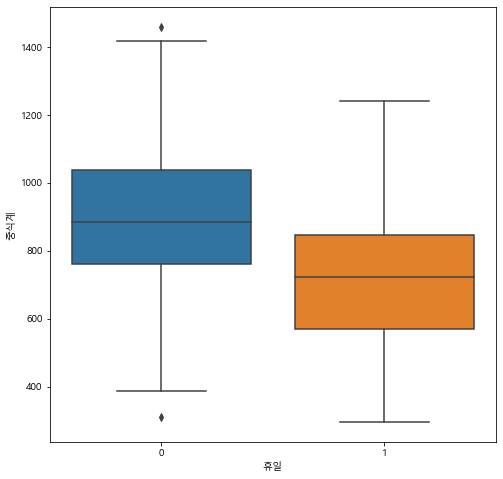

In [48]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(8, 8)

sns.boxplot(x='휴일', y='중식계', data=df)
# 휴일 근방이 되면 중식을 구내식당에서 먹는 인원이 줄어드는 경향이 있다, 유의한지는 통계분석 해봐야 한다.
# 아니면 금요일을 무조건 주말 전 휴일 전으로 설정하는 것이 좋을까?

<AxesSubplot:xlabel='휴일', ylabel='석식계'>

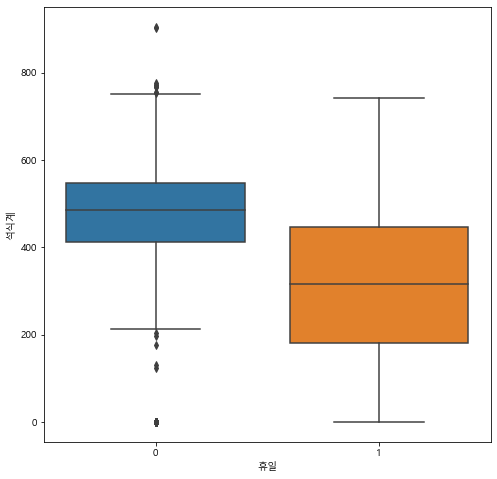

In [49]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(8, 8)

sns.boxplot(x='휴일', y='석식계', data=df)
# 휴일 근방이 되면 석식을 구내식당에서 먹는 인원이 줄어드는 경향이 있다, 유의한지는 통계분석 해봐야 한다.

In [50]:
df.to_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv", encoding="utf-8", index=False)

In [51]:
df = pd.read_csv("C:/Users/tagos71/Desktop/Team3/data/20220107train.csv", encoding="utf-8")
df

,일자,요일,본사정원수,실질정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,...,lunch_soup,lunch_main,dinner_rice,dinner_soup,dinner_main,평균기온(°C),일강수량(mm),평균 상대습도(%),휴일,휴일 전
0,2016-02-01,월,2601,2401,50,150,238,0,1039,331,...,오징어찌개,쇠불고기,밥,육개장,자반고등어구이,-0.6,0.0,43.9,0,0
1,2016-02-02,화,2601,2378,50,173,319,0,867,560,...,김치찌개,가자미튀김,콩나물밥*양념장,어묵국,유산슬,-2.3,0.0,47.5,0,0
2,2016-02-03,수,2601,2365,56,180,111,0,1017,573,...,팽이장국,치킨핑거,밥,청국장찌개,황태양념구이,-1.7,0.0,57.1,0,0
3,2016-02-04,목,2601,2277,104,220,355,0,978,525,...,쇠고기무국,주꾸미볶음,미니김밥*겨자장,우동,멕시칸샐러드,-0.2,0.0,53.4,0,0
4,2016-02-05,금,2601,2142,278,181,34,0,925,330,...,떡국,돈육씨앗강정,밥,차돌박이찌개,닭갈비,1.3,0.0,44.4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2021-01-20,수,2983,2319,75,198,4,391,1093,421,...,아욱국,수제함박스테이크,김치볶음밥,미니쫄우동*맛살튀김,브로콜리깨소스무침,-0.4,0.0,64.0,0,0
1201,2021-01-21,목,2983,2309,92,231,462,351,832,353,...,냉이된장국,동파육,밥,쇠고기무국,삼치양념구이,5.2,1.7,77.8,0,0
1202,2021-01-22,금,2983,2177,255,248,1,303,579,217,...,계란파국,요거닭,밥,수제비국,수제맛쵸킹탕수육,7.0,1.2,97.5,0,1
1203,2021-01-25,월,2983,2396,107,153,616,327,1145,502,...,전주식콩나물해장국,돈육간장불고기,밥,열무된장국,장어강정*데리야끼소스,6.3,0.0,75.8,0,0


# Checkpoint(2022.01.10 3pm)

+ 의미 있는 시각화 자료만 추려보자

<AxesSubplot:>

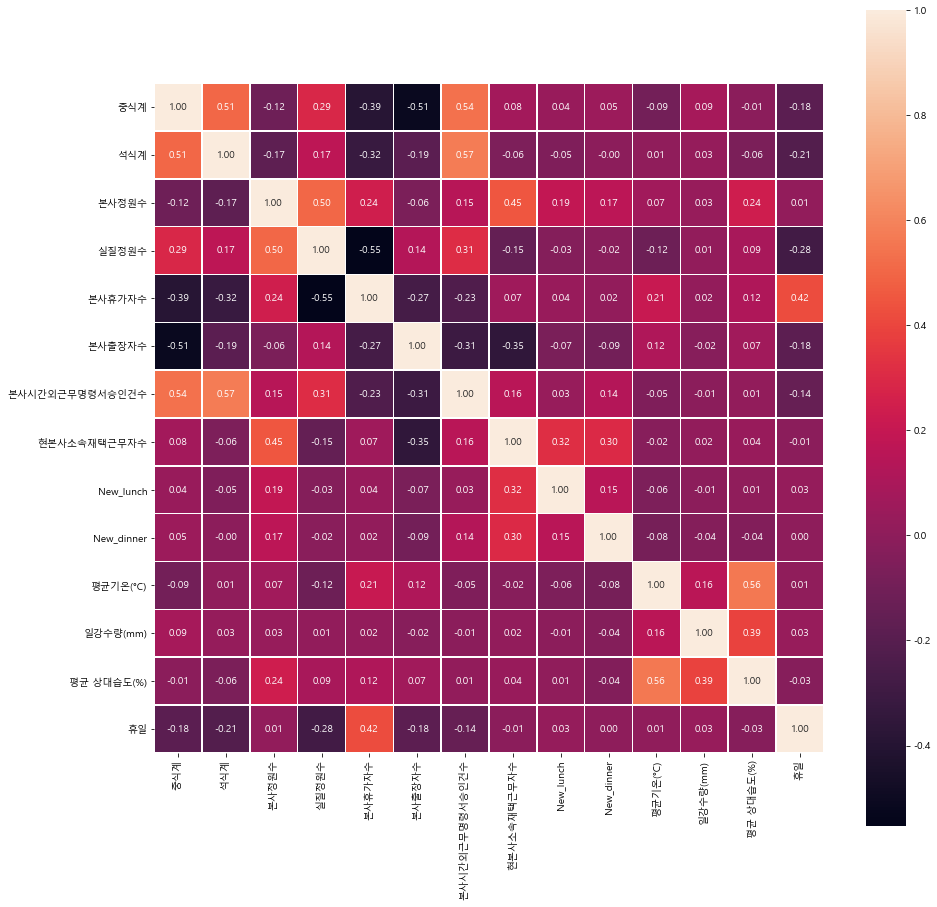

In [52]:
cols = ['중식계', '석식계', '본사정원수', '실질정원수', '본사휴가자수', '본사출장자수', 
        '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'New_lunch', 'New_dinner',
        '평균기온(°C)', '일강수량(mm)', '평균 상대습도(%)', '휴일']

plt.figure(figsize=(15,15))

heat = np.corrcoef(df[cols].T)
sns.heatmap(heat, annot=True, yticklabels=cols, xticklabels=cols, fmt='.2f', linewidths=.5, square=True)

# 정리: 중식계&석식계, 시간외&석식계, 본사휴가자수&휴일근처, 기온&상대습도  --> 양의 상관관계가 있을 것
# 정리: 본사휴가자수/본사출장자수&중식계와 석식계  --> 음의 상관관계가 있을 것

<AxesSubplot:xlabel='요일', ylabel='석식계'>

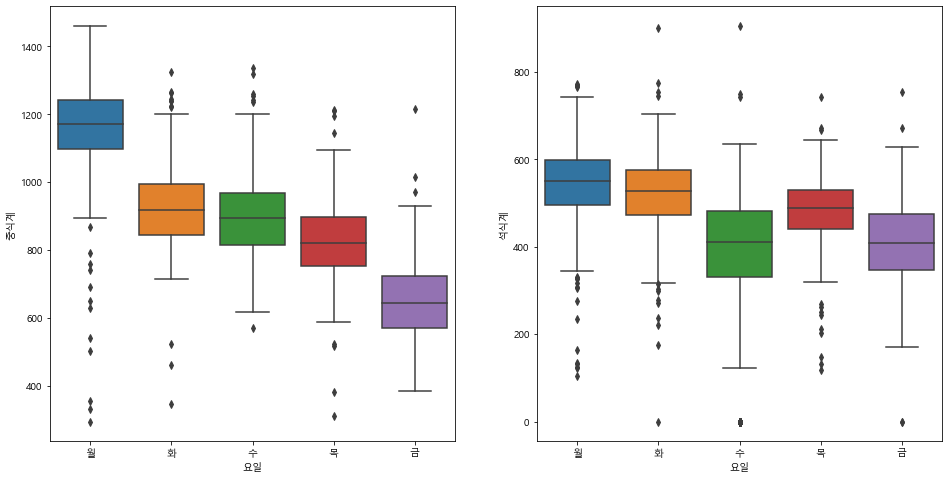

In [53]:
#요일 별 구내식당 이용인원(중식, 석식)
fig, axe = plt.subplots(1, 2, figsize=(16,8))

sns.boxplot(x='요일', y='중식계', data=df, ax = axe[0])
sns.boxplot(x='요일', y='석식계', data=df, ax = axe[1])

<AxesSubplot:xlabel='휴일', ylabel='석식계'>

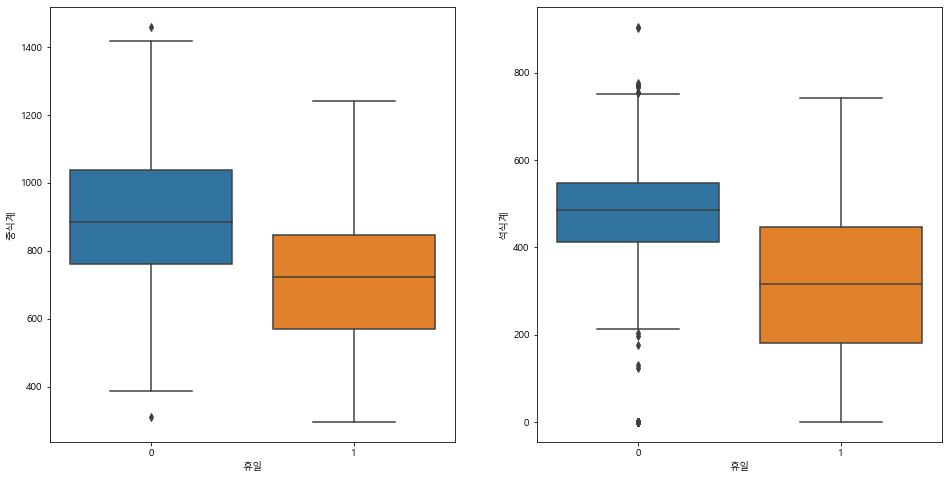

In [54]:
fig, axe = plt.subplots(1, 2, figsize=(16,8))

sns.boxplot(x='휴일', y='중식계', data=df, ax = axe[0])
sns.boxplot(x='휴일', y='석식계', data=df, ax = axe[1])

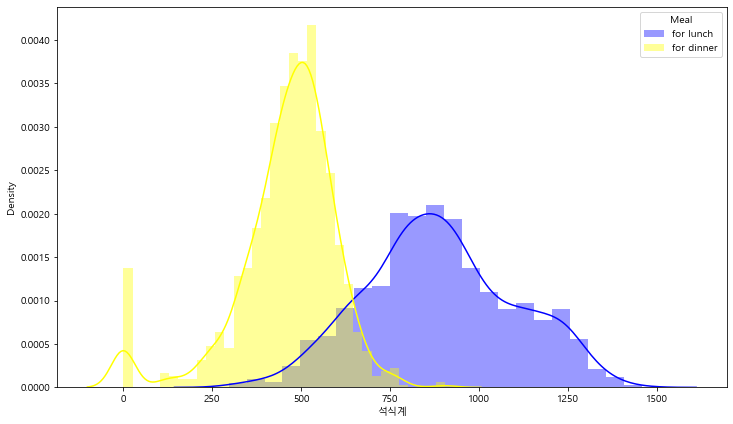

In [55]:
fig, axe = plt.subplots(figsize=(12,7))

sns.distplot(df['중식계'], color="blue", label="for lunch")

sns.distplot(df['석식계'], color="yellow", label="for dinner")

plt.legend(title="Meal")

plt.show()